In [3]:
import pandas as pd 
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("eleutherai/w2s")

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

all_runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

In [50]:
run_name = "multitrain_estop"
datasets = [
    "boolq",
    "anli-r2",
    "cosmos_qa",
    "mc_taco",
    "sciq",
    "paws",
    "twitter-sentiment",
    "wic"
]

runs_df = all_runs_df[all_runs_df.name.str.endswith(run_name)]
runs_df

,summary,config,name
1007,"{'train_runtime': 1379.5767, 'eval/val_auroc':...","{'bf16': False, 'fp16': False, 'fsdp': [], 'se...",cosmos_qa/s2s2_iter10_multitrain_estop
1009,"{'_wandb': {'runtime': 1382}, 'train_loss': 0....","{'bf16': False, 'fp16': False, 'fsdp': [], 'se...",cosmos_qa/s2s1_iter10_multitrain_estop
1010,"{'_wandb': {'runtime': 1459}, 'train_loss': 0....","{'bf16': False, 'fp16': False, 'fsdp': [], 'se...",cosmos_qa/s2s2_iter9_multitrain_estop
1011,"{'_timestamp': 1716032964.643483, 'eval/test_a...","{'bf16': False, 'fp16': False, 'fsdp': [], 'se...",anli-r2/s2s2_iter10_multitrain_estop
1012,"{'train/learning_rate': 0, '_wandb': {'runtime...","{'bf16': False, 'fp16': False, 'fsdp': [], 'se...",twitter-sentiment/s2s2_iter10_multitrain_estop
...,...,...,...
1249,"{'train_steps_per_second': 1.722, 'eval/test_s...","{'bf16': False, 'fp16': False, 'fsdp': [], 'se...",cosmos_qa/ceil_multitrain_estop
1251,"{'total_flos': 1.0269295330728346e+17, 'train/...","{'bf16': False, 'fp16': False, 'fsdp': [], 'se...",anli-r2/ceil_multitrain_estop
1257,"{'_timestamp': 1715991939.6003842, 'train/loss...","{'bf16': False, 'fp16': False, 'fsdp': [], 'se...",boolq/ceil_multitrain_estop
1259,"{'train_runtime': 487.9907, 'eval/test_loss': ...","{'bf16': False, 'fp16': False, 'fsdp': [], 'se...",cosmos_qa/floor_multitrain_estop


/tmp/ipykernel_2855166/3085602637.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s2s_ds_df["iter"] = s2s_ds_df["name"].apply(get_iter_from_name)
/tmp/ipykernel_2855166/3085602637.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s2s_ds_df["iter"] = s2s_ds_df["name"].apply(get_iter_from_name)
/tmp/ipykernel_2855166/3085602637.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

Using run boolq/floor_400steps_self for /floor of boolq


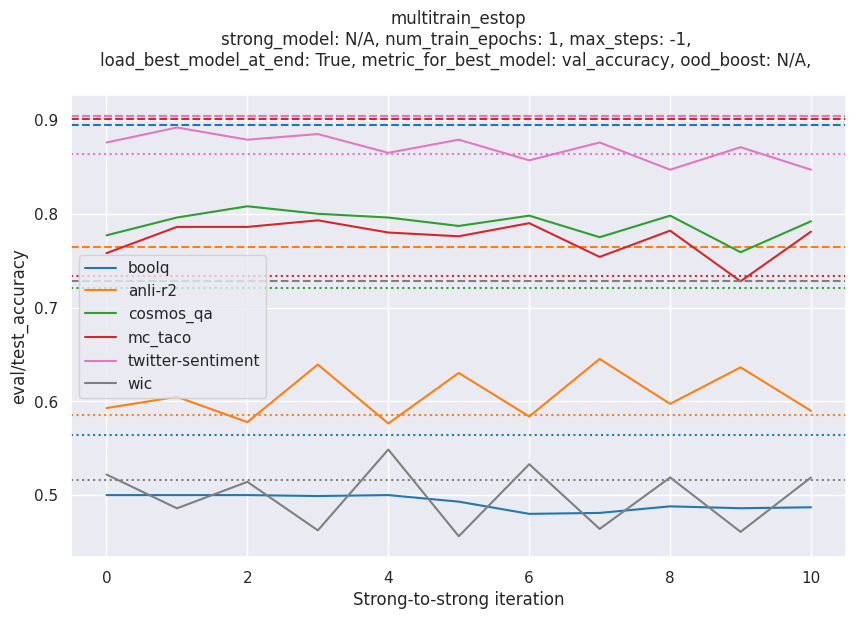

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# x axis: iter
# y axis: eval/test_auroc
# color: dataset

configs_to_report = [
    "strong_model",
    "num_train_epochs",
    "max_steps",
    "load_best_model_at_end",
    "metric_for_best_model",
    "ood_boost",
]


def get_config_str(config):
    # newline after every 3rd comma
    comma_count = 0
    multiline = ""
    for k in configs_to_report:
        v = config.get(k, "N/A")
        comma_count += 1
        multiline += f"{k}: {v}, "
        if comma_count % 3 == 0:
            multiline += "\n"
    return multiline


metric = "eval/test_accuracy"
config_str = None
colors = sns.color_palette("tab10", len(datasets))
plt.figure(figsize=(10, 6))
for color, ds in zip(colors, datasets):
    ds_df = runs_df[runs_df.name.str.contains(ds)]
    # remove rows without the metric
    s2s_ds_df = ds_df[ds_df.summary.apply(lambda x: metric in x) & (ds_df.name.str.contains("/s2s1") | ds_df.name.str.contains("/w2s1"))]

    def get_iter_from_name(name):
        if "/w2s" in name:
            return 0
        iter_idx = name.find("iter")
        next_under = name.find("_", iter_idx)
        return int(name[iter_idx+4:next_under])
    
    if len(s2s_ds_df) == 0:
        continue
    for config in s2s_ds_df["config"]:
        if config_str is None:
            config_str = get_config_str(s2s_ds_df.iloc[0]["config"])
        elif config_str != get_config_str(s2s_ds_df.iloc[0]["config"]):
            print("Different configs found!")
            print(get_config_str(s2s_ds_df.iloc[0]["config"]))
            print(config_str)
    
    s2s_ds_df["iter"] = s2s_ds_df["name"].apply(get_iter_from_name)
    
    plt.plot(s2s_ds_df["iter"], s2s_ds_df["summary"].apply(lambda x: x[metric]), label=ds, color=color)


    def get_limit(ceil=True):
        string = "/ceil" if ceil else "/floor"
        limit = ds_df[ds_df.name.str.contains(string)]
        if len(limit) > 0:
            if len(limit) > 1:
                print("Multiple floor runs found!")
            limit = limit.iloc[0]
            return limit["summary"].get(metric, None)
        else:
            # try to get it from all runs
            limit = all_runs_df[
                all_runs_df.name.str.contains(ds) & all_runs_df.name.str.contains(string)
            ]
            if len(limit) == 0:
                print(f"No {string} found for {ds}")
                return None
            limit = limit.iloc[0]
            print(f"Using run {limit['name']} for {string} of {ds}")
            return limit["summary"].get(metric, None)
        
    ceil = get_limit(ceil=True)
    floor = get_limit(ceil=False)
    if ceil is not None:
        plt.axhline(ceil, color=color, linestyle="--")
    if floor is not None:
        plt.axhline(floor, color=color, linestyle=":")

    
plt.legend()
title = f"{run_name}\n{config_str}"
plt.title(title)
plt.xlabel("Strong-to-strong iteration")
plt.ylabel(metric)
plt.show()


In [41]:
s2s_ds_df["config"].iloc[0]

{'bf16': False,
 'fp16': False,
 'fsdp': [],
 'seed': 42,
 'tf32': True,
 'debug': [],
 'optim': 'adamw_torch',
 'top_k': 50,
 'top_p': 1,
 'prefix': None,
 'do_eval': True,
 'no_cuda': False,
 'use_cpu': False,
 'do_train': False,
 'id2label': {'0': 'LABEL_0', '1': 'LABEL_1'},
 'label2id': {'LABEL_0': 0, 'LABEL_1': 1},
 'run_name': 'wic/s2s1_iter10_400steps',
 'use_ipex': False,
 'adafactor': False,
 'data_seed': None,
 'deepspeed': None,
 'do_sample': False,
 'hub_token': '<HUB_TOKEN>',
 'log_level': 'passive',
 'max_steps': 400,
 'num_beams': 1,
 'ray_scope': 'last',
 'report_to': ['wandb'],
 'typical_p': 1,
 'use_cache': True,
 'adam_beta1': 0.9,
 'adam_beta2': 0.95,
 'do_predict': False,
 'eval_delay': 0,
 'eval_steps': 100,
 'hidden_act': 'silu',
 'is_decoder': False,
 'local_rank': 0,
 'max_length': 20,
 'min_length': 0,
 'model_type': 'llama',
 'optim_args': None,
 'output_dir': 'new-results/wic/s2s1_iter10_400steps',
 'past_index': -1,
 'rope_theta': 500000,
 'save_steps': 100